In [1]:
import logging
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from hmmlearn.hmm import GMMHMM
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
class HpcPredictor(object):
    def __init__(self, file_name, latency = 5, test_size = 0.22, n_hidden_states = 5, n_mix = 2, 
                 n_steps_A = 20, n_steps_B = 20, n_steps_total_change = 100):
        
        self._init_logger()
        self.latency = latency
        self.split_train_test_data(file_name, test_size)
        #self.hmm = GMMHMM(n_components=n_hidden_states, n_mix=n_mix)
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        self._compute_all_possible_outcomes(n_steps_A, n_steps_B, n_steps_total_change)
    
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
    
    def split_train_test_data(self, file_name, test_size):
        data = pd.read_csv(file_name)
        data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
        train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
        self.train_data = train_data
        self.test_data = test_data
    
    def _extract_features(data):        
        # write featrue
        feature_A = np.array(data['Perf_node01_cpu_clock_change'])
        feature_B = np.array(data['Perf_node01_msr_tsc__change'])
        total_change = np.array(data['total_change'])
        
        return np.column_stack((feature_A, feature_B, total_change))
        
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vactor = HpcPredictor._extract_features(self.train_data)
        self._logger.info('Features extraction Completed <<<')
        self.hmm.fit(feature_vactor)
        
    def _compute_all_possible_outcomes(self, n_steps_A, n_steps_B, n_steps_total_change):
        feature_A_range = np.linspace(-0.3, 0.5, n_steps_A)
        feature_B_range = np.linspace(-0.3, 0.5, n_steps_B)
        total_change_range = np.linspace(-0.3, 0.5, n_steps_total_change)
        
        self._possible_outcomes = np.array(list(itertools.product(feature_A_range, feature_B_range, 
                                                                  total_change_range)))
        
    def _get_most_probable_outcome(self, index):
        previous_data_start_index = max(0, index - self.latency)
        previous_data_end_index = max(0, index)
        previous_data = self.test_data.iloc[previous_data_start_index : previous_data_end_index]
        previous_data_features = HpcPredictor._extract_features(previous_data)
             
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        
        most_probable_outcome = self._possible_outcomes[np.argmax(outcome_score)]
        return most_probable_outcome
    
    def predict_close_power(self, index):
        
        total_power = self.test_data.iloc[index]['pre_total']
        _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return total_power * (1 + predicted_total_change)
    
    def predict_close_change(self, index):
        
        _, _, predicted_total_change = self._get_most_probable_outcome(index)
        return predicted_total_change
    
    def predict_close_power_time(self, times, with_plot=False):
        predicted_close_power = []
        for index in tqdm(range(times)):
            predicted_close_power.append(self.predict_close_power(index))
        
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total']
            
            fig = plt.figure(figsize=(10,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_close_power, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            
        return predicted_close_power
    
    def predict_change_time(self, times, with_plot=False):
        predicted_change = []
        for index in tqdm(range(times)):
            predicted_change.append(self.predict_close_change(index))
            
        if with_plot:
            test_data = self.test_data[0:times]
            times = np.array(test_data['Unnamed: 0'])
            actual_total = test_data['total_change']
            
            fig = plt.figure(figsize=(15,8))
            
            axes = fig.add_subplot(111)
            axes.plot(times, actual_total, 'bo-', label='actual')
            axes.plot(times, predicted_change, 'r+-', label='predicted')
            
            plt.legend()
            plt.show()
            
        return predicted_change

2020-04-24 20:54:42,869 __main__     INFO     >>> Extracting Features
2020-04-24 20:54:42,869 __main__     INFO     >>> Extracting Features
2020-04-24 20:54:42,870 __main__     INFO     Features extraction Completed <<<
2020-04-24 20:54:42,870 __main__     INFO     Features extraction Completed <<<
100%|██████████| 50/50 [07:59<00:00,  9.58s/it]


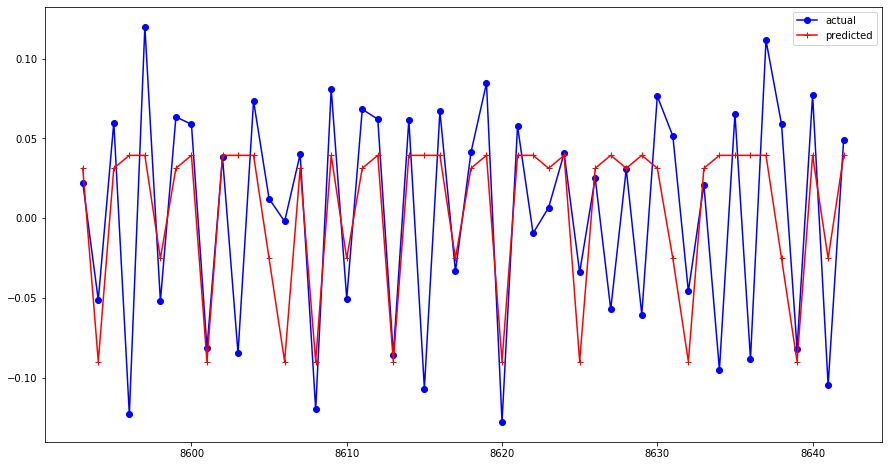

[0.03131313131313135,
 -0.0898989898989899,
 0.03131313131313135,
 0.039393939393939426,
 0.039393939393939426,
 -0.02525252525252525,
 0.03131313131313135,
 0.039393939393939426,
 -0.0898989898989899,
 0.039393939393939426,
 0.039393939393939426,
 0.039393939393939426,
 -0.02525252525252525,
 -0.0898989898989899,
 0.03131313131313135,
 -0.0898989898989899,
 0.039393939393939426,
 -0.02525252525252525,
 0.03131313131313135,
 0.039393939393939426,
 -0.0898989898989899,
 0.039393939393939426,
 0.039393939393939426,
 0.039393939393939426,
 -0.02525252525252525,
 0.03131313131313135,
 0.039393939393939426,
 -0.0898989898989899,
 0.039393939393939426,
 0.039393939393939426,
 0.03131313131313135,
 0.039393939393939426,
 -0.0898989898989899,
 0.03131313131313135,
 0.039393939393939426,
 0.03131313131313135,
 0.039393939393939426,
 0.03131313131313135,
 -0.02525252525252525,
 -0.0898989898989899,
 0.03131313131313135,
 0.039393939393939426,
 0.039393939393939426,
 0.039393939393939426,
 0.0393

In [6]:
hpc = HpcPredictor('perf_SP.csv')
hpc.fit()
#hpc.predict_close_power_time(20, with_plot=True)
hpc.predict_change_time(50, with_plot=True)